# Event Study Abnormal Returns

- CAR, BHAR, post-event drift, order statistics, Bonferroni adjustment
- S&P Key Developments, Wharton Research Data Services


Terence Lim

In [2]:
from finds.database import SQL
from finds.busday import BusDay
from finds.structured import PSTAT, CRSP, Benchmarks
from finds.backtesting import EventStudy
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import os
import time
from settings import settings
LAST_DATE = settings['crsp_date']

ECHO = False
sql = SQL(**settings['sql'], echo=ECHO)
user = SQL(**settings['user'], echo=ECHO)
bd = BusDay(sql)
keydev = PSTAT(sql, bd)
crsp = CRSP(sql, bd, rdb=None)
bench = Benchmarks(sql, bd)
eventstudy = EventStudy(user, bench, LAST_DATE)
outdir = os.path.join(settings['images'], 'events')

# event window parameters
end = bd.begmo(LAST_DATE)
beg = 19890101
minobs = 250
left, right, post = -1, 1, 21

# str formatter to pretty print event and role description given their id's 
eventformat = lambda e, r: "{event} ({eventid}) {role} [{roleid}]".format(
    event=keydev.event_[e], eventid=e, role=keydev.role_[r], roleid=r)
events = sorted(keydev.event_.keys())   # list of eventid's
roles = sorted(keydev.role_.keys())     # list of roleid's

## Helpers to merge events and crsp, and screen stock universe                      


In [3]:
# to lookup prevailing exchange and share codes by permno and date
shrcd = crsp.build_lookup('permno', 'shrcd')
exchcd = crsp.build_lookup('permno', 'exchcd')

def event_pipeline(eventstudy, mincap=300000, **arg):
    """helper to merge keydev events and crsp, and screen stock universe"""
    df = keydev.get_linked(
        dataset='keydev',
        date_field='announcedate',
        fields=['keydevid',
                'keydeveventtypeid',
                'keydevtoobjectroletypeid'],
        where=(f"announcedate >= {arg['beg']} and announcedate <= {arg['end']}"
               f" and keydeveventtypeid = {arg['eventid']} "
               f" and keydevtoobjectroletypeid = {arg['roleid']}"))\
               .drop_duplicates(['permno','announcedate'])\
               .set_index(['permno','announcedate'], drop=False)
    
    stk = arg['stocks'].get_many(
        dataset='daily',
        permnos=df['permno'],
        date_field='date',
        dates=arg['stocks'].bd.offset(df['announcedate'], left-1),
        fields=['prc', 'shrout']).fillna(0)
    
    df['cap'] = (stk['prc'].abs() * stk['shrout']).values
    df['exchcd'] = [exchcd(r.permno, r.date) for r in stk.itertuples()]
    df['shrcd'] = [shrcd(r.permno, r.date) for r in stk.itertuples()]
    r = (df['cap'].gt(mincap) &              # require cap > $300M
         df['exchcd'].isin([1,2,3]) &        # primary exchange
         df['shrcd'].isin([10,11])).values   # domestic common stocks
    rows = eventstudy(crsp, df[r], left, right, post, 'announcedate')
    return df.loc[rows.to_records(index=False).tolist()]  # restrict df to rows

## Compute abnormal returns of all events

In [ ]:
# store images and output here
htmlfile = os.path.join(outdir, 'index.html')
with open(htmlfile, 'wt') as f:
    f.write(f"Event study CAR<br>\n")
    f.write(f" car:  {right-left+1}-day CAR around announce day<br>\n")
    f.write(f" post: drift from day+{right+1} to day+{post}<br>\n<p>\n")
        
tic = time.time()
for i, eventid in enumerate(events):
    for roleid in roles:
        # retrieve all observations of this eventid, roleid
        df = event_pipeline(eventstudy, stocks=crsp, beg=beg, end=end,
                            eventid=eventid, roleid=roleid,
                           left=left, right=right, post=post)
        if len(df) < minobs:  # require min number of events
            continue
        
        # retrieve announcement window returns
        r = eventstudy(crsp, df, left, right, post, 'announcedate')
        if r['date'].nunique() < minobs:  # require min number of dates
            continue

        # compute both BHAR and CAR averages, plot and save
        bhar = eventstudy.fit(car=False, name='bhar')
        car = eventstudy.fit(car=True, name='car')
        eventstudy.write(label=f"{eventid}_{roleid}")
        s = pd.concat([bhar, car], axis=1).T
        print(eventformat(eventid, roleid))
        print(s.to_string())
        print()
        fig, axes = plt.subplots(2, 1, clear=True, num=1, figsize=(10,12))
        eventstudy.plot(title=eventformat(eventid, roleid),
                        vline=right, ax=axes[0], name='bhar')
        eventstudy.plot(title='', vline=right, ax=axes[1], name='car')
        if outdir:
            plt.savefig(os.path.join(outdir, f"{eventid}_{roleid}.jpg"))
            
        with open(htmlfile, 'at') as f:
            f.write(f"<p><h3>{eventformat(eventid, roleid)}</h3><pre>\n")
            f.write(s.to_string())
            f.write(f"</pre><img src='{os.path.basename(savefig)}'><hr>\n")
    #print(i, eventid, 'Elapsed:', time.time()-tic, 'secs')

plt.close()

## Summarize BHAR's of all events
- sorted by 3-day window abnormal returns

In [5]:
df = eventstudy.read(name='bhar').set_index('permno').sort_values('window', ascending=False)
dx = DataFrame(df.index.str.split('_').to_list()).astype(int)
df.index = pd.MultiIndex.from_frame(dx).set_names(['eventid','roleid'])

df['event'] = keydev.event_[df.index.get_level_values(0)].values
df['role'] = keydev.role_[df.index.get_level_values(1)].values

mindays = (df['days']>1000).values
pd.set_option('max_rows', 999)
df[mindays].drop(columns='name')


,,beg,end,rows,days,effective,window,window_t,post,post_t,event,role
eventid,roleid,,,,,,,,,,,
80,1,19890221,20201116,3382,2526,879.0,0.177791,26.684800,-0.001516,-0.375123,M&A Transaction Announcements,Target
52,1,20031027,20201119,4554,2409,529.0,0.044859,9.637150,-0.003627,-0.845517,M&A Calls,Target
27,1,20011217,20201119,14573,3332,605.0,0.026843,10.429800,0.001506,0.411760,Corporate Guidance - Raised,Target
63,1,20041021,20201113,1688,1285,446.0,0.017157,3.356090,-0.005981,-0.965471,Considering Multiple Strategic Alternatives,Target
94,1,20020429,20201120,1505,1107,476.0,0.016158,6.271870,0.007931,1.730840,Special Dividend Announced,Target
157,1,20001020,20201119,3732,2289,600.0,0.013806,5.296940,-0.003144,-0.653575,Investor Activism - Activist Communication,Target
83,1,19890102,20201119,3156,2323,863.0,0.012551,3.349050,-0.012898,-1.972130,Private Placements,Target
65,1,19900906,20201120,18170,4624,947.0,0.011012,6.434530,-0.001241,-0.361197,M&A Rumors and Discussions,Target
232,1,19930928,20201120,11624,3795,840.0,0.008831,4.686620,0.004522,1.512780,Buyback Transaction Announcements,Target


## Event-window BHAR
- by median cap
- by half sample period

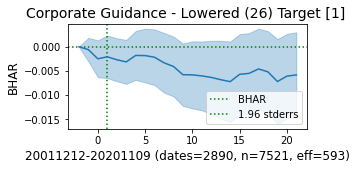

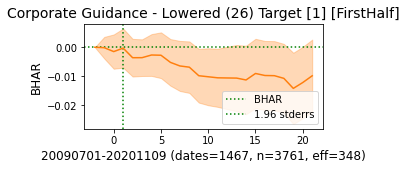

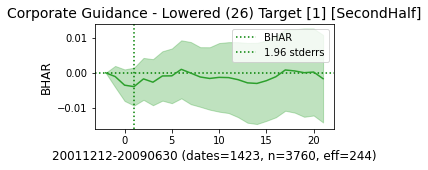

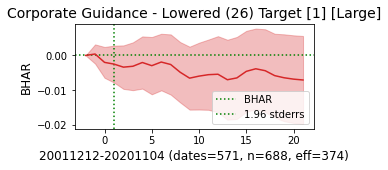

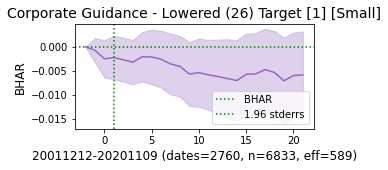

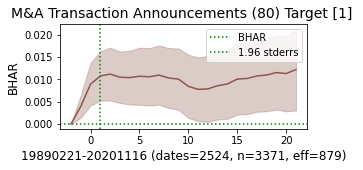

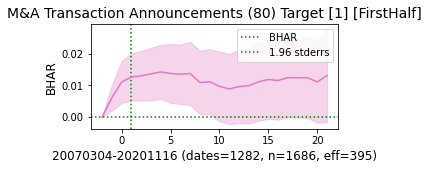

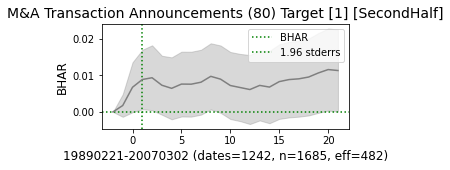

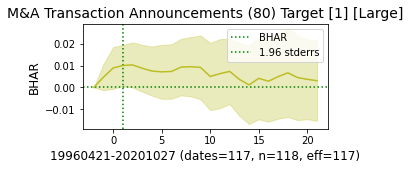

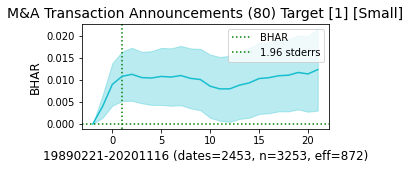

In [26]:
midcap = 20000000    
for i, (eventid, roleid) in enumerate([[26,1],[80,1]]):
    df = event_pipeline(eventstudy, stocks=crsp, eventid=eventid, roleid=roleid,
                        beg=beg, end=end, left=left, right=right, post=post)
    halfperiod = np.median(df['announcedate'])
    sample = {'': None,
              '[FirstHalf]': df['announcedate'].ge(halfperiod).values,
              '[SecondHalf]': df['announcedate'].lt(halfperiod).values,
              '[Large]': df['cap'].ge(midcap).values,
              '[Small]': df['cap'].lt(midcap).values}
    for ifig, (label, rows) in enumerate(sample.items()):
        fig, ax = plt.subplots(clear=True, num=1+ifig, figsize=(5,3))
        bhar = eventstudy.fit(rows=rows, car=False)
        eventstudy.plot(title=eventformat(eventid, roleid) + ' ' + label,
                        drift=False, ax=ax, c=f"C{i*5+ifig}")
        plt.savefig(os.path.join(outdir, label + f"{eventid}_{roleid}.jpg"))
        plt.show()

## Plot post-event drift BHAR
- by median cap
- by half sample period

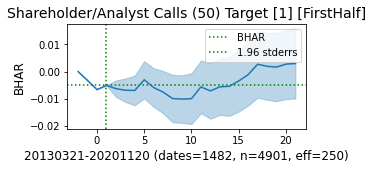

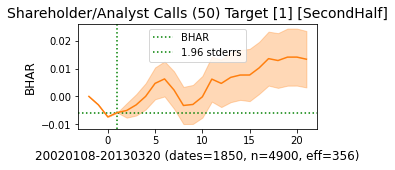

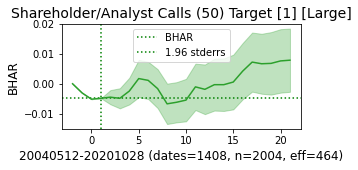

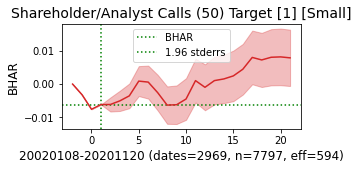

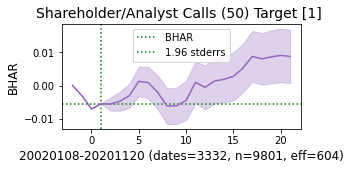

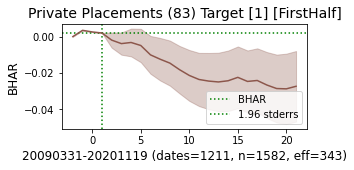

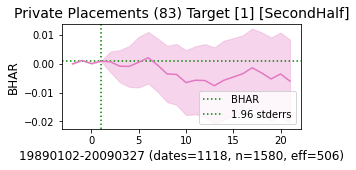

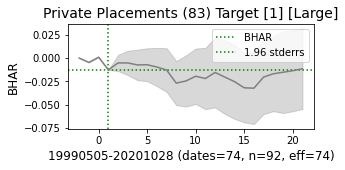

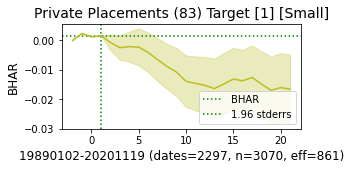

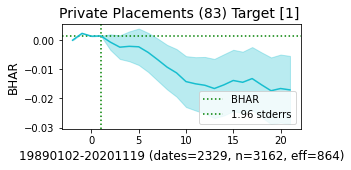

In [25]:
midcap = 20000000    
for i, (eventid, roleid) in enumerate([[50,1], [83,1]]):
    df = event_pipeline(eventstudy, stocks=crsp, eventid=eventid, roleid=roleid,
                        beg=beg, end=end, left=left, right=right, post=post)
    halfperiod = np.median(df['announcedate'])
    sample = {'': None,
              '[FirstHalf]': df['announcedate'].ge(halfperiod).values,
              '[SecondHalf]': df['announcedate'].lt(halfperiod).values,
              '[Large]': df['cap'].ge(midcap).values,
              '[Small]': df['cap'].lt(midcap).values}
    for ifig, (label, rows) in enumerate(sample.items()):
        fig, ax = plt.subplots(clear=True, num=1+ifig, figsize=(5,3))
        bhar = eventstudy.fit(rows=rows, car=False)
        eventstudy.plot(title=eventformat(eventid, roleid) + ' ' + label,
                        drift=True, ax=ax, c=f"C{i*5+ifig}")
        plt.savefig(os.path.join(outdir, label + f"{eventid}_{roleid}.jpg"))
        plt.show()

## Max Order Statistic

In [23]:
    import statsmodels.api as sm
    import scipy
    from pandas.api import types
    class MaxStat:
        """Max Order Statistic probability distributions"""
        def __init__(self, dist=scipy.stats.norm, n=None, **params):
            self.dist_ = dist
            self.params_ = params
            self.n = n

        def cdf(self, z, n=None):
            """cdf for max order statistic"""
            return [self.cdf(y, n) for y in z] if types.is_list_like(z)\
                else self.dist_.cdf(z, **self.params_)**(n or self.n)

        def pdf(self, z, n=None):
            """cdf for max order statistic"""
            n = n or self.n
            return [self.pdf(y, n) for y in z] if types.is_list_like(z)\
                else self.dist_.pdf(z, **self.params_) * n * self.cdf(z, n=n-1)

        def ppf(self, z, n=None):
            """inverse cdf for max order statistic"""
            return [self.ppf(y, n) for y in z] if types.is_list_like(z)\
                else self.dist_.ppf(z, **self.params_)**(n or self.n)
        
        def pvalue(self, z, n=None):
            """z-value for max order statistic"""
            return [self.pvalue(y, n) for y in z] if types.is_list_like(z)\
                else 1 - (self.dist_.cdf(z, **self.params_)**(n or self.n))
        
        def zvalue(self, p, n=None):
            """z-value for max order statistic"""
            return [self.zvalue(y, n) for y in z] if types.is_list_like(p)\
                else self.dist_.ppf((1-p)**(1/(n or self.n)), **self.params_)

        def bonferroni(self, p, n=None):
            """corrected z-value with with Bonferroni adjustment"""
            return [self.bonferroni(y, n) for y in z] if types.is_list_like(p)\
                else self.dist_.ppf((1-(p/n)), **self.params_)
        
    y = eventstudy.read(name='bhar')['post_t'].values
    Z = max(y)
    n = len(y)
    print(f"Events tested={n}, Max z-value={Z:.4f}\n")
    maxstat = MaxStat(scipy.stats.foldnorm, c=0)
    
    p = Series({n: maxstat.pvalue(Z, n=n) for n in
                sorted([n] + [1, 2, 30, 60, 120, 250, 1000, 1600])}, name='pvalue')
    print(f"\nMax order statistic p-value(z={Z:.2f}) by sample size:")
    DataFrame(p).T


Sample size of events tested=92, Max z-value=3.5135


Max order statistic p-value(z=3.51) by sample size:


,1,2,30,60,92,120,250,1000,1600
pvalue,0.000442,0.000884,0.013181,0.026189,0.039874,0.051691,0.104679,0.357438,0.507208


In [11]:
P=0.05
print(f"\nRejection Region(p-value={P:.2f}) by sample size:")
zb = Series({n: maxstat.bonferroni(P, n=n)
             for n in [1, 2, 20, 100, 1000, 100000, 1000000]},name='max-order')
zc = Series({n: maxstat.zvalue(P, n=n)
             for n in [1, 2, 20, 100, 1000, 100000, 1000000]},name='bonferroni')
pd.concat([zc, zb], axis=1).round(3)


Rejection Region(p-value=0.05) by sample size:


,bonferroni,max-order
1,1.960,1.960
2,2.236,2.241
20,3.016,3.023
100,3.474,3.481
1000,4.050,4.056
100000,5.021,5.026
1000000,5.447,5.451


## Plot CDF of Max Order Statistic by Sample Size

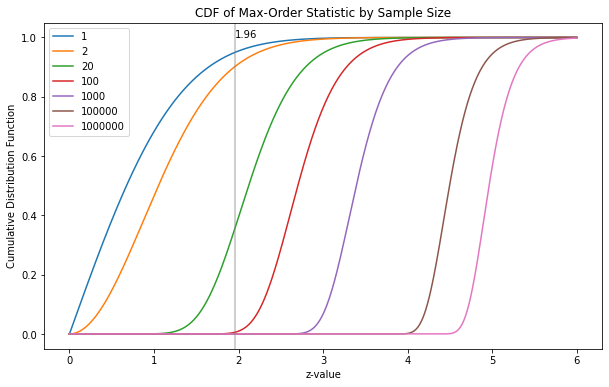

In [9]:
X = np.linspace(0, 6, 600)
df = DataFrame(index=X)
df = pd.concat([Series(data=[maxstat.cdf(x, n) for x in X], index=X, name=n)
                for n in [1, 2, 20, 100, 1000, 100000, 1000000]], axis=1)
fig, ax = plt.subplots(clear=True, num=1, figsize=(10,6))
df.plot(ax=ax, title='CDF of Max-Order Statistic by Sample Size',
        xlabel='z-value', ylabel='Cumulative Distribution Function')
ax.axvline(1.96, c='grey', alpha=0.5)
ax.annotate("1.96", xy=(1.96, 1))
plt.savefig(os.path.join(outdir, 'cdf.jpg'))

## Distribution of post-event t-values

,count,mean,std,min,25%,50%,75%,max
post_t,92.0,-0.032715,1.027028,-1.97213,-0.660091,-0.051404,0.530975,3.51353


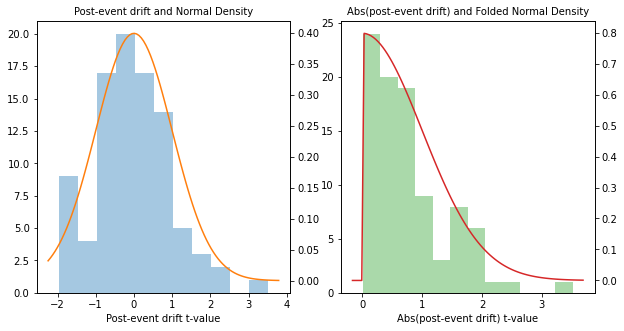

In [7]:
    import seaborn as sns
    y = eventstudy.read(name='bhar')['post_t']
    fig, axes = plt.subplots(1, 2, num=1, clear=True, figsize=(10,5))
    
    ax = sns.distplot(y, kde=False, hist=True, ax=axes[0], color='C0')
    bx = ax.twinx()
    x = np.linspace(*plt.xlim(), 100)
    bx.plot(x, scipy.stats.norm.pdf(x), color="C1")
    ax.set_title('Post-event drift and Normal Density', fontsize=10)
    ax.set_xlabel('Post-event drift t-value')

    ax = sns.distplot(abs(y), kde=False, hist=True, ax=axes[1],
                      color='C2')
    bx = ax.twinx()
    x = np.linspace(*plt.xlim(), 100)
    bx.plot(x, scipy.stats.foldnorm.pdf(x, 0), color="C3")
    ax.set_title('Abs(post-event drift) and Folded Normal Density', fontsize=10)
    ax.set_xlabel('Abs(post-event drift) t-value')
    plt.savefig(os.path.join(outdir, 'hist.jpg'))
    DataFrame(y.describe()).T
    